<a href="https://colab.research.google.com/github/graviada/DataScienceProjects/blob/main/PetProjects/Toxic_Comments_BinaryClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Задача бизнеса:**
    Необходимо разработать модель, которая будет удалять негативные комментарии на форуме. Нужно максимизировать количество удаляемых комментариев.
### **Постановка задачи:**
    - разработать бинарный классификатор (воспользуемся логистической регрессией);
    - максимизировать метрику Recall (нашли все плохие комментарии);
    - добиться Precision > 0.95 (комментарий реально является негативным).

Так как мы не обладаем размеченной выборкой для обучения модели, возможно использование готового датасета с негативными и позитивными комментариями на русском языке.

Для реализации модели был выбран датасет Russian Language Toxic Comments Dataset.

Он представляет собой коллекцию аннотированных комментариев с сайтов Двач и Пикабу. Опубликован на Kaggle в 2019-м и содержит 14 412 комментариев, из которых 4 826 помечены как токсичные, а 9 586 — как нетоксичные. Средняя длина комментария 175 символов, минимальная — 21, максимальная — 7 403.

### **Импорт библиотек**

In [124]:
import random
from google.colab import files

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, plot_precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Загрузка датасета с Kaggle**

In [ ]:
# Грузим json-файл с ключем
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"irinachalova","key":"3d68b18a63cbb1fb592d9e53facb0454"}'}

In [ ]:
# Загружаем API-клиента Kaggle
!pip install -q kaggle

In [ ]:
# Kaggle API-клиент ожидает, что мы сохраним скаченный файл в ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Это изменение разрешений позволяет избежать предупреждения при запуске инструмента Kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Отобразим доступные датасеты
!kaggle datasets list

ref                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/date-fruit-datasets                 Date Fruit Datasets                              408KB  2022-04-03 09:25:39            931        205  0.9375           
datasets/piterfm/2022-ukraine-russian-war                      2022 Ukraine Russia War                            2KB  2022-04-18 08:46:30           9003        498  1.0              
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36             75        183  0.9375           
datasets/kamilpytlak/personal-key-indicators-of-heart-disease  Personal Key Indi

In [ ]:
!kaggle datasets download -d blackmoon/russian-language-toxic-comments

  0% 0.00/1.49M [00:00<?, ?B/s]
100% 1.49M/1.49M [00:00<00:00, 75.3MB/s]


In [ ]:
!ls

kaggle.json  russian-language-toxic-comments.zip  sample_data


In [ ]:
!unzip russian-language-toxic-comments.zip

Archive:  russian-language-toxic-comments.zip
  inflating: labeled.csv             


In [ ]:
!ls

kaggle.json  labeled.csv  russian-language-toxic-comments.zip  sample_data


### **Разведочный анализ данных (англ. exploratory data analysis, EDA)**

Загрузим данные в переменную df и посмотрим характеристики исследуемого датасета.

In [ ]:
df = pd.read_csv('labeled.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


In [ ]:
# Приведем тип данных колонки toxic из float64 к типу int
df['toxic'] = df['toxic'].apply(int)

df.tail(5)

,comment,toxic
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1
14411,До сих пор пересматриваю его видео. Орамбо кст...,0


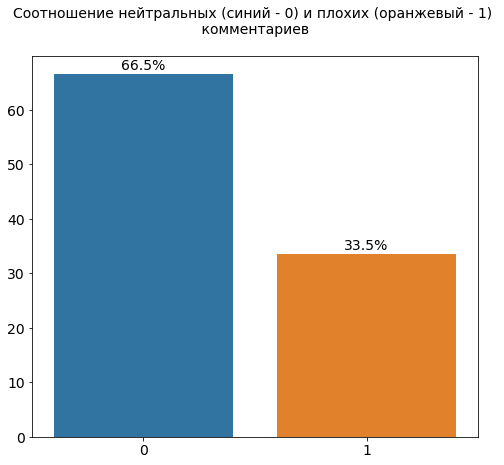

In [ ]:
# Посмотрим распределение значений в переменной toxic
norm_target = (df
               .toxic
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(8, 7))
ax = sns.barplot(x='index', y='percent', data=norm_target)

# Вывод значений над графиками - annotate()
# В цикле смотрим каждый столбец графика и на нем отмечаем значения
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center', # центрирование
                va='center',
                xytext=(0, 9),
                textcoords='offset points', # точка смещения относительно координаты
                fontsize=14)

plt.title('Соотношение нейтральных (синий - 0) и плохих (оранжевый - 1) \n комментариев \n', fontsize=14)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [ ]:
df['toxic'].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

Рассмотрим сами комментарии.

In [ ]:
# Токсичные комменатрии
for c in df[df['toxic'] == 1]['comment'].tail(5):
  print(c)

ЖЕНЩИНА это ВЕНЕЦ ТВОРЕНИЯ, помните это ваньки! Вы все не стоите одной женской какашки, лошки! Женщины правят цивилизацией! На колени хуемрази! Феминизм победил! КНН

Сейчас все авиакомпании мира вместе со специалистами гугл карт смотрят на казахов и думают ну что за дебилы ну еп твое мать.

Вонючий совковый скот прибежал и ноет. А вот и сторонник демократии и свободы слова закукарекал.

А кого любить? Гоблина тупорылого что-ли? Или какую-нибудь продажную суку из демшизы? Нет уж, спасибо не надо.

КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ НЕТ ОБСУЖДЕНИЯ ПОЛИТИКИ. СВОБОДНОЕ ОБЩЕНИЕ ЭТО В b. ЭТО ТОЖЕ САМОЕ ЕСЛИ Я НА ДОСКЕ О ПОЛИТИКЕ СОЗДАМ ТРЕД О ТОМ КАК ПЛОХО БЕЗ ТЯНОЧКИ. ТАК ЧТО УЕБЫВАЙТЕ В Б ИЛИ НВР СО СВОИМ ЧАТИКОМ ПРЕСТАРЕЛЫХ ГОМОСЕКОВ!



In [ ]:
# Нейтральные комменатрии
for c in df[df['toxic'] == 0]['comment'].tail(5):
  print(c)

ТАСС, 21 марта. Премьер-министр Новой Зеландии Джасинда Ардерн ввела в четверг запрет на оборот и эксплуатацию штурмовых и полуавтоматических винтовок на территории страны. Об этом говорится в официальном заявлении, распространенном в четверг и опубликованном на сайте новозеландского правительства. В понедельник, через 72 часа после ужасного террористического акта в Крайстчерче кабинет министров согласился пересмотреть закон. Теперь, через шесть дней после этого нападения, мы объявляем о запрете на все полуавтоматические и штурмовые винтовки военного образца в Новой Зеландии , - говорится в заявлении. Все виды полуавтоматического оружия, которые были использованы во время теракта в пятницу, 15 марта, будут запрещены . Отмечается, что под запрет также попадут приспособления, с помощью которых можно переделать оружие в полуавтоматическое военного образца, и магазины большой емкости. Помимо этого, кабинет министров поручил разработать схему выкупа оружия подобного типа у его владельцев. И

По содержанию видно, что некоторые комментарии в датасете ошибно размечены как нейтральные. Поэтому полученная далее модель априори не будет достаточно хороша для задачи, хотя ее качество и можно улучшить с помощью изменения гиперпараметров.

### **Предобработка текста**

In [ ]:
# Разделение исходных данных на обучающую и тестовые выборки
random.seed(7)

train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=random.randint(0, 10),
                                     shuffle=True)

In [ ]:
print(f'Размер обучающей выборки: {train_df.shape} \nРазмер тестовой выборки: {test_df.shape}')

Размер обучающей выборки: (11529, 2) 
Размер тестовой выборки: (2883, 2)


Теперь наша задача состоит в том, чтобы на вход будущей модели подавались вещественные векторы, а не текст. Для этого нужно:
> 1. Разбить исходный текст на токены.
> 2. Удалить знаки препинания.
> 3. Удалить стоп-слова (междометия и т. д.)
> 4. Применить стеминг (удалить у слова окончание и привести все к нижнему регистру).

In [86]:
snowball = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')

def tokenize_sentence(sentence: str, remove_stop_words: bool = True) -> list:
  tokens = word_tokenize(sentence, language='russian')
  # Токены без пунктуации
  tokens = [i for i in tokens if i not in string.punctuation]
  if remove_stop_words:
    # Токены без пунктуации и стоп-слов
    tokens = [i for i in tokens if i not in russian_stop_words]
  tokens = [snowball.stem(i) for i in tokens]
  return tokens

In [88]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [89]:
features = vectorizer.fit_transform(train_df['comment'])

### **Создание модели машинного обучения и ее оптимизация**

In [91]:
model = LogisticRegression(random_state=0)
model.fit(features, train_df['toxic'])

LogisticRegression(random_state=0)

Модернизируем наши входные данные с помощью пайплайна, чтобы в модель можно было сразу подавать текст, а не вектор.

In [136]:
model_pipeline = Pipeline([
  ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
  ('model', LogisticRegression(random_state=0))
])

In [98]:
model_pipeline.fit(train_df['comment'], train_df['toxic'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f8d0497a9e0>)),
                ('model', LogisticRegression(random_state=0))])

In [113]:
model_pipeline.predict(["Я гулять"])

array([0])

In [114]:
# False-negative
model_pipeline.predict(['Этот фильм дно'])

array([0])

In [115]:
# False-positive
model_pipeline.predict(['Привет, я пошел гулять'])

array([1])

Теперь посмотрим на метрики.

In [118]:
precision_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict(test_df['comment']))

0.9021084337349398

In [119]:
recall_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict(test_df['comment']))

0.6118488253319714

Такое значение Precision нас не устраивает по требованию задачи. Соотвественно, мы можем изменить порог для вероятности логистической регрессии.

Порог разделения в бинарном классификаторе можно пронаблюдать с помощью вывода Precision-Recall кривой.

In [121]:
# Массивы precision, recall и порога бинарного классификатора thresholds
prec, rec, thresholds = precision_recall_curve(y_true=test_df['toxic'], probas_pred=model_pipeline.predict_proba(test_df['comment'])[:, 1])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


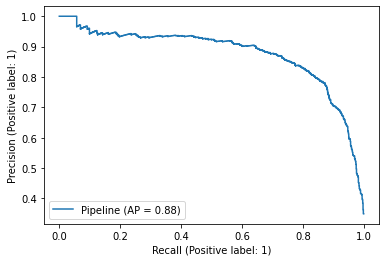

In [122]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df['comment'], y=test_df['toxic'])

Видно, что при желании мы можем использовать максимальный Precision и удалять только ТОЧНО негативные комментарии (в них у нас будет наибольшая уверенность). Однако при этом Recall стремится к 0, то есть количество удаляемых комментариев будет минимально.

Посмотрим, в какой момент метрика Precision будет больше 0.95 и выведем порог (threshold) с этим индексом.

In [125]:
np.where(prec > 0.95)

(array([2666, 2667, 2668, 2669, 2670, 2671, 2672, 2691, 2692, 2693, 2694,
        2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705,
        2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716,
        2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727,
        2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738,
        2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749,
        2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760,
        2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771,
        2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782,
        2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792]),)

In [127]:
thresholds[2666]

0.8447680073293975

Теперь попробуем вызвать предсказания с полученным порогом.

In [132]:
precision_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict_proba(test_df['comment'])[:, 1] > thresholds[2666])

0.9523809523809523

In [133]:
recall_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict_proba(test_df['comment'])[:, 1] > thresholds[2666])

0.12257405515832483

Попробуем улучшить гиперпараметры модели с помощью GridSearch, отсматривающий их. Выдает те гиперпараметры, которые на кросс-валидации показывают наилучшие метрики.

Попробуем менять коэффициент регуляризации.

In [138]:
grid_pipeline = Pipeline([
  ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
  ('model', 
    GridSearchCV(
      LogisticRegression(random_state=0),
      # Здесь мы перебираем 3 коэффициента регуляризации
      param_grid={'C': [.1, 1, 9.]},
      # Бьем выборку на 3 части и мешаем ее
      cv=3,
      # Максимальный вербоз, выводим всю информацию по обучению
      verbose=4
    )
  )
])

In [139]:
grid_pipeline.fit(train_df['comment'], train_df['toxic'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.683 total time=   0.3s
[CV 2/3] END .............................C=0.1;, score=0.679 total time=   0.3s
[CV 3/3] END .............................C=0.1;, score=0.680 total time=   0.3s
[CV 1/3] END ...............................C=1;, score=0.828 total time=   0.6s
[CV 2/3] END ...............................C=1;, score=0.826 total time=   0.6s
[CV 3/3] END ...............................C=1;, score=0.831 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/3] END .............................C=9.0;, score=0.861 total time=   0.9s
[CV 2/3] END .............................C=9.0;, score=0.859 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/3] END .............................C=9.0;, score=0.862 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f8d03e94b00>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 9.0]}, verbose=4))])

In [140]:
model_pipeline_c9 = Pipeline([
  ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
  ('model', LogisticRegression(random_state=0, C=9.))
])

In [141]:
model_pipeline_c9.fit(train_df['comment'], train_df['toxic'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f8d03d6f8c0>)),
                ('model', LogisticRegression(C=9.0, random_state=0))])

In [142]:
# Массивы precision, recall и порога бинарного классификатора thresholds
prec_c9, rec_c9, thresholds_c9 = precision_recall_curve(y_true=test_df['toxic'], probas_pred=model_pipeline_c9.predict_proba(test_df['comment'])[:, 1])

In [145]:
np.where(prec_c9 > 0.95)

(array([2494, 2495, 2496, 2497, 2498, 2499, 2509, 2510, 2511, 2512, 2513,
        2514, 2515, 2516, 2517, 2518, 2519, 2536, 2537, 2538, 2539, 2543,
        2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554,
        2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565,
        2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576,
        2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587,
        2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598,
        2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609,
        2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2637,
        2638, 2639, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2664, 2665,
        2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676,
        2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687,
        2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698,
        2699, 2700, 2701, 2702, 2703, 

In [146]:
precision_score(y_true=test_df['toxic'], y_pred=model_pipeline_c9.predict_proba(test_df['comment'])[:, 1] > thresholds_c9[2494])

0.9507692307692308

In [148]:
recall_score(y_true=test_df['toxic'], y_pred=model_pipeline_c9.predict_proba(test_df['comment'])[:, 1] > thresholds_c9[2494])

0.31562819203268644

Как видно, нам удалось поднять значение метрики Recall с 0.1226 до 0.3156.